# **Pipeline de Modelagem para Predição de Default** 


## **1. Introdução**


Este notebook tem como objetivo a criação, treinamento e otimização de um modelo preditivo para prever o default de clientes. 

* O pipeline inclui:

    *  Tratamento e engenharia de features para melhorar a qualidade dos dados.
    *  Divisão entre treino e teste para avaliação do modelo.
    *  Implementação de diferentes modelos de ML para comparação (Regressão Logística, Random Forest e XGBoost)
    *  Ajuste de hiperparâmetros para otimização do melhor modelo.

Para garantir um pipeline modular e reutilizável, foi utilizado um *Custom Transformer* (salvo no diretório src/ do repositório).

A modelagem foi estruturada usando um Pipeline do Scikit-Learn, garantindo que todas as etapas do fluxo sejam replicáveis e padronizadas. 

Esse pipeline foi salvo como um objeto .pkl, facilitando o reuso da pipeline no notebook de predição.


In [32]:
# importando bibliotecas necessárias 
import pandas as pd
import numpy as np
from pathlib import Path 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

import sys
sys.path.append("../src")
from custom_transformers import FeatureEngineeringTransformer

import joblib

import warnings
warnings.filterwarnings("ignore")

### 2. Carregando os dados 

*  Os dados utilizados foram carregados a partir do arquivo .csv (dataset_2021-5-26-10-14.csv), presente na pasta data/ deste repositório.

In [2]:
# identificando diretório base 
base_dir = Path.cwd()

# caminho para a pasta contendo o dataset  
data_dir = base_dir.parent / "data"

# caminho para o dataset 
df_path = data_dir / "dataset_2021-5-26-10-14.csv"

# importando o arquivo csv para um dataframe pandas
df = pd.read_csv(df_path, sep="\t", encoding="utf-8")

df.head()

,default_3months,ioi_36months,ioi_3months,valor_por_vencer,valor_vencido,valor_quitado,quant_protestos,valor_protestos,quant_acao_judicial,acao_judicial_valor,...,dividas_vencidas_qtd,falencia_concordata_qtd,tipo_sociedade,opcao_tributaria,atividade_principal,forma_pagamento,valor_total_pedido,month,year,default
0,0,58.000000,18.236092,0.00,0.0,242100.70,0,0.0,0,0.0,...,0,0,empresario (individual),simples nacional,papelaria,30/60/90,34665.674938,6,2019,0
1,1,16.052632,7.500000,224132.85,0.0,4960846.21,0,0.0,0,0.0,...,0,0,sociedade empresaria limitada,missing,com de equipamentos de informatica,30/60/90,7134.489373,10,2018,0
2,0,13.250000,3.904762,513043.83,0.0,158631.93,1,1800.0,0,0.0,...,0,0,sociedade empresaria limitada,simples nacional,servicos de vigilancia e guarda,missing,72653.621143,4,2018,0
3,0,136.925000,10.144219,23273.64,0.0,669644.16,0,0.0,0,0.0,...,0,0,empresario (individual),simples nacional,com de equipamentos de informatica,missing,14576.805783,4,2017,1
4,0,140.333333,17.651678,0.00,0.0,2010.56,0,0.0,0,0.0,...,0,0,sociedade empresaria limitada,simples nacional,com de compon eletron e pecas para eletrod,30/60/90,2655.505663,10,2017,0


### 3. Pré-processamento e Engenharia de Features

Para melhorar o desempenho do modelo, foi aplicada uma série de transformações nos dados.

**1. Remoção de valores e variáveis**

*  Remoção de valores ausentes das variáveis (`tipo_sociedade` e `atividade_principal`) (com poucos "missings" - apenas ~0.5%)

*  Remoção de variável sem variância (`participacao_falencia_valor`), com apenas um valor. 

*  Remoção das linhas com valores negativos em `valor_total_pedido`.

*  Remoção da variável `year` 


**2. Conversão de tipos**

*  Algumas variáveis numéricas foram convertidas de float para inteiro (int) (ex: variáveis que representam dias)


**3. Binarização**

*  Criação de colunas binárias para os valores ausentes das variáveis (ex: `opcao_tributaria` e `forma_pagamento`) e variáveis com muitos zeros (ex: `quant_protestos`, `quant_acao_judicial`). 


**4. Transformação logarítmica**

*  Aplicação de log1p (logaritmo + 1) em variáveis financeiras para suavizar distribuições com grandes discrepâncias.


**5. Criação de novas features derivadas**

*  Proporção de valores vencidos (`prop_vencido`) e proporção de valores quitados (`prop_quitado`).

*  Razão entre `ioi_3months` e `ioi_36months` (ratio_ioi).

*  Score Bureau (`score_bureau`): Indica se o cliente já teve qualquer tipo de problema financeiro.

*  Criação de variável temporal com `Month` - transformado em trimestre


**6. Agrupamento de categorias:**

*  `tipo_sociedade` foi agrupado por mesmo tipo de natureza jurídica e frequência relativa de cada categoria

*  `atividade_principal` foi agrupado em comércio, indústria, serviços, educação, etc.

* `forma_pagamento` foi transformado em categorias curto, médio, longo e muito longo.

In [3]:
# removendo linhas do dataframe
df = df.loc[(df['tipo_sociedade'] != 'missing') &  (df['atividade_principal'] != 'missing')].copy()
df = df[df['valor_total_pedido'] >= 0].copy()
df = df[df['forma_pagamento'] != 'sem_pagamento'].copy()
df.drop('participacao_falencia_valor', axis=1, inplace=True)

In [4]:
# remover o ano
df = df.drop(columns=['year'])

In [5]:
print(df['default'].value_counts(normalize=True))

default
0    0.832904
1    0.167096
Name: proportion, dtype: float64


### 4 - Separação em treino e teste

Para avaliar o desempenho do modelo, os dados foram divididos em treino (80%) e teste (20%).

In [6]:
# definindo x como todas as colunas exceto 'default' e y como 'default' (alvo)

y = df['default']

x = df.drop('default', axis=1)

In [7]:
# dividindo os dados em treino e teste 
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.2, 
    random_state=13, 
    stratify=y
)

print("X_train:", x_train.shape)
print("X_test:", x_test.shape)

X_train: (93206, 19)
X_test: (23302, 19)


### 5. Construção da pipeline

In [8]:
# aplicando as transformações por custom transformer 
feature_engineering = FeatureEngineeringTransformer()

In [9]:
x_transformed = feature_engineering.fit_transform(x_train)

x_transformed.head()

,ioi_36months,ioi_3months,opcao_tributaria,default_3months_bin,log1p_valor_por_vencer,log1p_valor_vencido,log1p_valor_quitado,log1p_dividas_vencidas_valor,log1p_valor_total_pedido,prop_vencido,...,score_bureau,tipo_sociedade_agrupado,n_parcelas,prazo_medio,prazo_maximo,classificacao_prazo,opcao_tributaria_missing,forma_pagamento_missing,atividade_agrupada,trimestre
92156,56,15,simples nacional,0,0.000000,0.000000,10.610097,0.0,8.854277,0.000000,...,0,individual,5.0,90.0,150.0,longo,0,0,outros,3
1697,48,72,simples nacional,0,8.393341,0.000000,12.437259,0.0,8.250925,0.000000,...,0,individual,3.0,35.0,42.0,medio,0,0,comercio,1
75093,6,5,simples nacional,0,11.604523,0.000000,14.591262,0.0,8.989037,0.000000,...,0,sociedade empresarial,3.0,42.0,56.0,medio,0,0,comercio,4
15013,8,6,simples nacional,0,8.486284,0.000000,13.192647,0.0,8.236939,0.000000,...,0,sociedade empresarial,5.0,56.0,70.0,medio,0,0,comercio,3
113101,5,8,simples nacional,0,11.371928,8.743139,14.390566,0.0,8.934497,0.003362,...,0,individual,5.0,56.0,70.0,medio,0,0,comercio,2


In [10]:
#determinando as colunas numéricas e categóricas
num_features = x_transformed.select_dtypes(include=["int64", "float64"]).columns
cat_features = x_transformed.select_dtypes(include=["object", "category"]).columns

In [11]:
# pipeline para variáveis numéricas 
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=-1)), ('scaler', StandardScaler())])

# pipeline para variáveis categóricas   
cat_pipeline = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [12]:
# aplicando transformacoes 
preprocessor = ColumnTransformer([('num', num_pipeline, num_features),('cat', cat_pipeline, cat_features)])

In [13]:
# modelos a serem testados/comparados
model_dict = { 
    "Logistic_Regression": LogisticRegression(random_state=42, class_weight='balanced'),
    "RandomForest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(random_state=42, scale_pos_weight=(len(y_train) - sum(y_train))/sum(y_train)),
}

### 7-Avaliação de modelos 

Análises através de uma função de avaliação de performance de diferentes modelos (Regressão Logística, RandomForest e XGBoost)

In [14]:
# testar os modelos e obter métricas 
def compara_modelos(model, x_train, y_train, x_test, y_test, model_name= "Model"):
    '''

    Função que treina um modelo e retorna métricas, curva roc e matriz de confusão

    '''

    clf = Pipeline([("feature_engineering", feature_engineering), ("preprocessor", preprocessor),("classifier", model)])

    # treinar o modelo
    clf.fit(x_train, y_train)

    # prediz no conjunto de teste
    y_pred = clf.predict(x_test)
    y_prob = clf.predict_proba(x_test)[:,1]

    # prediz no conjunto de treino
    y_train_pred = clf.predict(x_train)
    y_train_prob = clf.predict_proba(x_train)[:, 1]

    # métricas teste 
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

     # métricas treino
    rec_train = recall_score(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_train_prob)
    acc_train = accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)
    prec_train = precision_score(y_train, y_train_pred)

    # printar as metricas 
    print(f"\n =========== {model_name} =========== ")
    print(f"Classification report teste:")
    print(classification_report(y_test, y_pred, digits=4))


    print(f"TESTE: Acurácia: {acc:.2f}, Precisão {prec:.2f}, Recall: {rec:.2f}, F1: {f1:.2f}, AUC: {auc:.2f}\n")
    print(f"TREINO: Acurácia: {acc_train:.2f}, Precisão {prec_train:.2f}, Recall: {rec_train:.2f}, F1: {f1_train:.2f}, AUC: {auc_train:.2f}\n")

    # matriz de confusão
    print(f"\nMatriz de Confusão teste\n")
    matriz = confusion_matrix(y_test, y_pred)
    print(matriz)

    # análise de overfitting
    print("\nComparação para Overfitting:")
    print(f"Diferença AUC (Treino - Teste): {auc_train - auc:.4f}")
    print(f"Diferença Recall (Treino - Teste): {rec_train - rec:.4f}")

    # curva roc
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, marker='.', label=f"{model_name} (AUC = {auc:.2f})")
        plt.xlabel('Taxa de Falsos Positivos')
        plt.ylabel('Taxa de Verdadeiros Positivos')
        plt.title('Curva Roc')
        plt.legend()
        plt.show()

    return {
        "Modelo": model_name,
        "Acurácia": acc,
        "Precisão": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc,
        "Overfitting_Recall": rec_train - rec,
        "Overfitting_AUC": auc_train - auc
    }

/home/maiara/miniconda3/envs/X-health-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 =========== Logistic_Regression =========== 
Classification report teste:
              precision    recall  f1-score   support

           0     0.9262    0.7156    0.8074     19408
           1     0.3356    0.7160    0.4570      3894

    accuracy                         0.7156     23302
   macro avg     0.6309    0.7158    0.6322     23302
weighted avg     0.8275    0.7156    0.7488     23302

TESTE: Acurácia: 0.72, Precisão 0.34, Recall: 0.72, F1: 0.46, AUC: 0.79

TREINO: Acurácia: 0.71, Precisão 0.33, Recall: 0.71, F1: 0.45, AUC: 0.79


Matriz de Confusão teste

[[13888  5520]
 [ 1106  2788]]

Comparação para Overfitting:
Diferença AUC (Treino - Teste): -0.0056
Diferença Recall (Treino - Teste): -0.0057


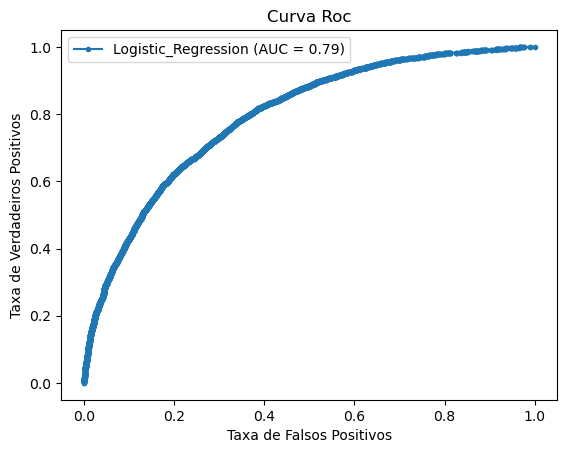


 =========== RandomForest =========== 
Classification report teste:
              precision    recall  f1-score   support

           0     0.8997    0.9864    0.9411     19408
           1     0.8699    0.4517    0.5947      3894

    accuracy                         0.8971     23302
   macro avg     0.8848    0.7191    0.7679     23302
weighted avg     0.8947    0.8971    0.8832     23302

TESTE: Acurácia: 0.90, Precisão 0.87, Recall: 0.45, F1: 0.59, AUC: 0.91

TREINO: Acurácia: 1.00, Precisão 1.00, Recall: 1.00, F1: 1.00, AUC: 1.00


Matriz de Confusão teste

[[19145   263]
 [ 2135  1759]]

Comparação para Overfitting:
Diferença AUC (Treino - Teste): 0.0923
Diferença Recall (Treino - Teste): 0.5482


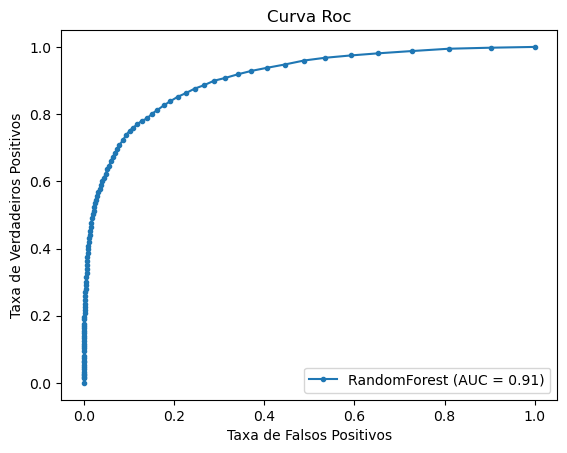


 =========== XGBoost =========== 
Classification report teste:
              precision    recall  f1-score   support

           0     0.9498    0.8326    0.8873     19408
           1     0.4834    0.7807    0.5971      3894

    accuracy                         0.8239     23302
   macro avg     0.7166    0.8066    0.7422     23302
weighted avg     0.8719    0.8239    0.8388     23302

TESTE: Acurácia: 0.82, Precisão 0.48, Recall: 0.78, F1: 0.60, AUC: 0.89

TREINO: Acurácia: 0.85, Precisão 0.53, Recall: 0.87, F1: 0.66, AUC: 0.94


Matriz de Confusão teste

[[16159  3249]
 [  854  3040]]

Comparação para Overfitting:
Diferença AUC (Treino - Teste): 0.0446
Diferença Recall (Treino - Teste): 0.0891


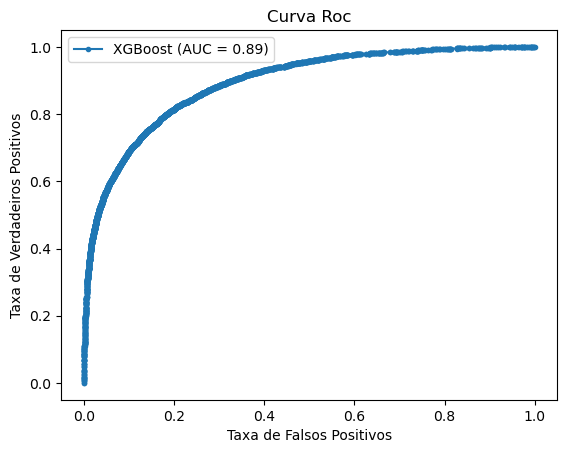

In [15]:
results = []

for name, clf in model_dict.items():
    metrics = compara_modelos(
        clf, 
        x_train, y_train, 
        x_test, y_test, 
        model_name=name
    )
    results.append(metrics)

Comparação de Performance

In [16]:
comparison = pd.DataFrame(results)
display(comparison)

,Modelo,Acurácia,Precisão,Recall,F1,AUC,Overfitting_Recall,Overfitting_AUC
0,Logistic_Regression,0.715647,0.335580,0.715973,0.456974,0.793153,-0.005687,-0.005608
1,RandomForest,0.897090,0.869931,0.451721,0.594659,0.907661,0.548151,0.092339
2,XGBoost,0.823921,0.483384,0.780688,0.597074,0.893300,0.089095,0.044552


Escolhido XGBoost --> bom equilíbrio entre Recall e Precisão 

In [17]:
# modelo escolhido para otimização --> XGBoost
xgb_model = XGBClassifier(random_state=42,scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train))

### 8- Otimização de Hiperparâmetros

*  Foi utilizada a técnica RandomizedSearchCV para encontrar os melhores hiperparâmetros do modelo XGBoost.

In [18]:
# criar pipeline para o modelo XGBoost 
pipeline_xgb = Pipeline([("feature_engineering", feature_engineering), ("preprocessor", preprocessor),("classifier", xgb_model)])

In [19]:
# parâmetros para otimização do modelo XGBoost
param = {'classifier__n_estimators': [50, 100, 200, 300, 500],
    'classifier__max_depth': [3, 5, 6],
    'classifier__learning_rate': np.linspace(0.01, 0.3, 5),
    'classifier__subsample': np.linspace(0.5, 1.0, 5),
    'classifier__colsample_bytree': np.linspace(0.5, 1.0, 5),
    'classifier__gamma': [0, 1, 3, 5],
    'classifier__reg_lambda': np.logspace(-2, 1, 5), 
    'classifier__reg_alpha': np.logspace(-2, 1, 5)}


random_search = RandomizedSearchCV(
    estimator=pipeline_xgb,
    param_distributions=param,
    n_iter=20,  
    scoring='recall',  
    cv=3,  
    verbose=2,
    random_state=42
)

# rodar a busca de hiperparâmetros
random_search.fit(x_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END classifier__colsample_bytree=0.875, classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__reg_alpha=1.7782794100389228, classifier__reg_lambda=0.05623413251903491, classifier__subsample=0.875; total time=   8.5s
[CV] END classifier__colsample_bytree=0.875, classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__reg_alpha=1.7782794100389228, classifier__reg_lambda=0.05623413251903491, classifier__subsample=0.875; total time=   8.8s
[CV] END classifier__colsample_bytree=0.875, classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__reg_alpha=1.7782794100389228, classifier__reg_lambda=0.05623413251903491, classifier__subsample=0.875; total time=   8.6s
[CV] END classifier__colsample_bytree=0.875, classifier__gamma=5, classifier__lea

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('feature_engineering',
                                              FeatureEngineeringTransformer()),
                                             ('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value=-1,
                                                                                                              strategy='constant')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['ioi_36months', 'ioi_3months', 'default_3months_bin',
       'log1p_valor_por_vencer'...
                                        'classifier__learning_rate': array([0.01  , 0.0825, 0.155 , 0.2275, 0.3   ]),
                                        'classifier__max_depth': [3, 5, 6],
                                        'classifier__n_estimators': [50, 100,
                                                                     200, 300,
                                                                     500],
                                        'classifier__reg_alpha': array([ 0.01      ,  0.05623413,  0.31622777,  1.77827941, 10.        ]),
                                        'classifier__reg_lambda': array([ 0.01      ,  0.05623413,  0.31622777,  1.77827941, 10.        ]),
                                        'classifier__subsample': array([0.5  , 0.625, 0.75 , 0.875, 1.   ])},
                   random_state=42, scoring='recall', verbose=2)

In [20]:
# os melhores hiperparâmetros encontrados são:
print("Melhores hiperparâmetros:", random_search.best_params_)
print("Melhor recall obtido:", random_search.best_score_)

Melhores hiperparâmetros: {'classifier__subsample': np.float64(0.875), 'classifier__reg_lambda': np.float64(10.0), 'classifier__reg_alpha': np.float64(10.0), 'classifier__n_estimators': 500, 'classifier__max_depth': 5, 'classifier__learning_rate': np.float64(0.08249999999999999), 'classifier__gamma': 1, 'classifier__colsample_bytree': np.float64(0.75)}
Melhor recall obtido: 0.7703868860776678


In [21]:
# rodar modelo com hiperparâmetros encontrados em random_search 
best_pipeline = random_search.best_estimator_

best_pipeline.fit(x_train, y_train)
y_pred = best_pipeline.predict(x_test)

In [22]:
# métricas do modelo otimizado teste 
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
y_prob = best_pipeline.predict_proba(x_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)

print(f"TESTE: Acurácia: {acc:.2f}, Precisão {prec:.2f}, Recall: {rec:.2f}, F1: {f1:.2f}, AUC: {auc:.2f}\n")

# métricas do modelo otimizado treino
y_pred_train = best_pipeline.predict(x_train)
y_prob_train = best_pipeline.predict_proba(x_train)[:, 1]

acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train)
rec_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)
auc_train = roc_auc_score(y_train, y_prob_train)

print(f"TREINO: Acurácia: {acc_train:.2f}, Precisão {prec_train:.2f}, Recall: {rec_train:.2f}, F1: {f1_train:.2f}, AUC: {auc_train:.2f}")

TESTE: Acurácia: 0.81, Precisão 0.46, Recall: 0.79, F1: 0.58, AUC: 0.89

TREINO: Acurácia: 0.83, Precisão 0.49, Recall: 0.84, F1: 0.62, AUC: 0.92


In [31]:
# salvando modelo na pasta model do repositório
joblib.dump(best_pipeline, "../model/pipeline_predicao_default.pkl")

['../model/pipeline_predicao_default.pkl']

### 9 - Análise de Features Relevantes

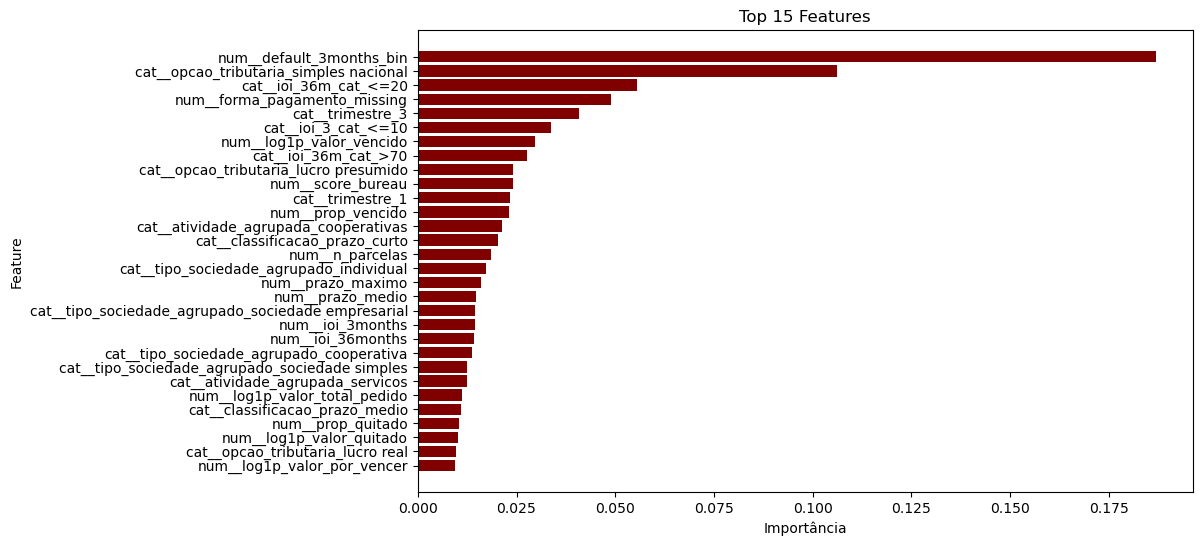

                                              Feature  Importance
2                            num__default_3months_bin    0.186882
21             cat__opcao_tributaria_simples nacional    0.106073
24                              cat__ioi_36m_cat_<=20    0.055577
16                       num__forma_pagamento_missing    0.049008
49                                   cat__trimestre_3    0.040840
28                                cat__ioi_3_cat_<=10    0.033640
4                            num__log1p_valor_vencido    0.029717
25                               cat__ioi_36m_cat_>70    0.027746
18              cat__opcao_tributaria_lucro presumido    0.024205
11                                  num__score_bureau    0.024128
47                                   cat__trimestre_1    0.023270
8                                   num__prop_vencido    0.022997
41               cat__atividade_agrupada_cooperativas    0.021251
35                     cat__classificacao_prazo_curto    0.020320
12        

In [24]:
importances = best_pipeline["classifier"].feature_importances_
feature_names = best_pipeline["preprocessor"].get_feature_names_out()

# cria df de importancia das features
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# plot de top 15 features mais importantes
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"][:30], feature_importance_df["Importance"][:30], color='maroon')
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.title("Top 15 Features")
plt.gca().invert_yaxis()  
plt.show()

print(feature_importance_df.head(61))


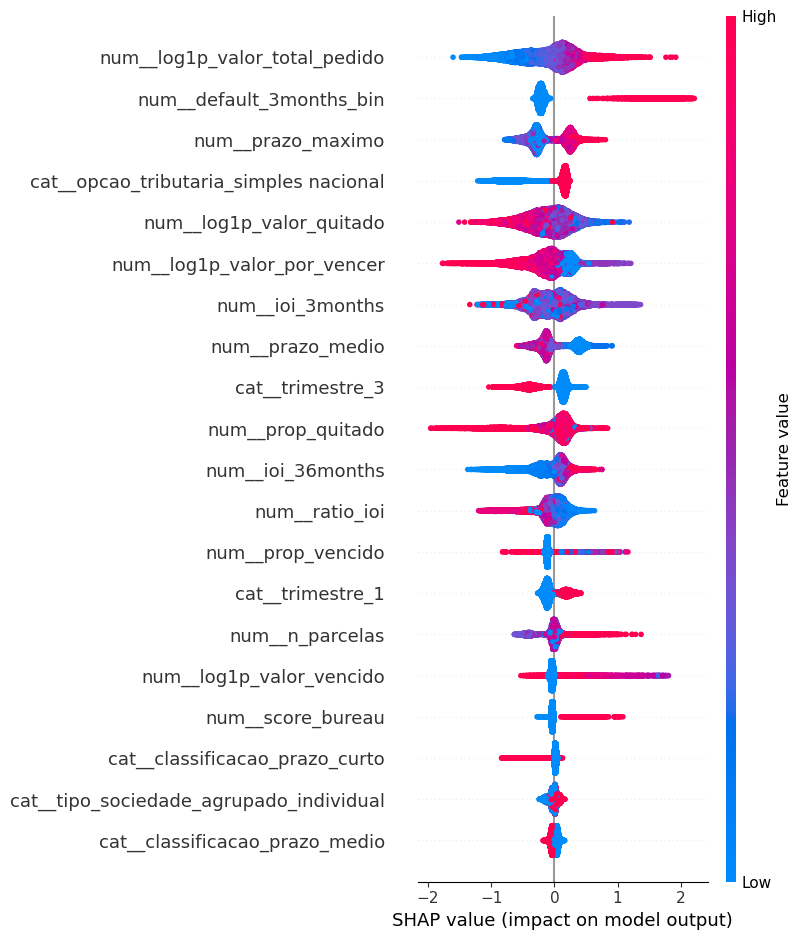

In [25]:
import shap

# análise de variáveis com SHAP 
explainer = shap.Explainer(best_pipeline["classifier"])
X_test_processed = best_pipeline[:-1].transform(x_test)

explainer = shap.TreeExplainer(best_pipeline["classifier"])

shap_values = explainer(X_test_processed)

feature_names = best_pipeline["preprocessor"].get_feature_names_out()
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names)